# Установка зависимостей

In [21]:
import re
import os
from google.colab import drive, files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from torch.utils.data import TensorDataset, DataLoader
import warnings
import seaborn as sns
from tqdm import tqdm
import torch
import gc

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = # my path

# EDA

In [23]:
df = pd.read_json(path, orient ='records')
df

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


In [5]:
df.shape[0]

39774

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [7]:
cols = df.columns
cols

Index(['id', 'cuisine', 'ingredients'], dtype='object')

In [8]:
df[cols[:2]].nunique()

id         39774
cuisine       20
dtype: int64

In [9]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
massive_products = list(set(ingredient for sublist in df['ingredients'] for ingredient in sublist))
voc_products = {ingredient: i + 1 for i, ingredient in enumerate(massive_products)}
df['ingredients'] = df['ingredients'].apply(lambda x: [voc_products[ingredient] for ingredient in x])
for i, ingredient in tqdm(enumerate(massive_products), total=len(massive_products)):
    df[f'ingredient{i+1}'] = df['ingredients'].apply(lambda x: 1 if i+1 in x else 0)

warnings.simplefilter(action='default', category=pd.errors.PerformanceWarning)

100%|██████████| 6714/6714 [05:07<00:00, 21.86it/s]


In [ ]:
df.head()

,id,cuisine,ingredients,ingredient1,ingredient2,ingredient3,ingredient4,ingredient5,ingredient6,ingredient7,...,ingredient6705,ingredient6706,ingredient6707,ingredient6708,ingredient6709,ingredient6710,ingredient6711,ingredient6712,ingredient6713,ingredient6714
0,10259,greek,"[3787, 4373, 1038, 4460, 2152, 3210, 4361, 395...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,25693,southern_us,"[3591, 1117, 6399, 1759, 3243, 1614, 2540, 383...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20130,filipino,"[2540, 2152, 6399, 6007, 1165, 3136, 5088, 541...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22213,indian,"[3097, 6264, 4354, 6399]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13162,indian,"[1790, 1291, 6202, 499, 260, 4575, 300, 6454, ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ingredient_columns = df.columns[3:]
ingredient_sums = df[ingredient_columns].sum()

In [ ]:
# Гистограмма топ 10 самых используемых ингредиентов
top_10_ingredients = ingredient_sums.nlargest(10)
print(top_10_ingredients.index)

Index(['ingredient6399', 'ingredient260', 'ingredient1280', 'ingredient3097',
       'ingredient4460', 'ingredient2687', 'ingredient2360', 'ingredient6454',
       'ingredient3243', 'ingredient2966'],
      dtype='object')


In [ ]:
digits = []
# Извлечение цифр с использованием регулярного выражения
for ingredient in top_10_ingredients.index:
    index_ingr = int(re.findall(r'\d+', ingredient)[0])
    for key, value in voc_products.items():
        if value == index_ingr:
            digits.append(key)
# digits теперь содержит список цифр из строки индекса
digits

['salt',
 'onions',
 'olive oil',
 'water',
 'garlic',
 'sugar',
 'garlic cloves',
 'butter',
 'ground black pepper',
 'all-purpose flour']

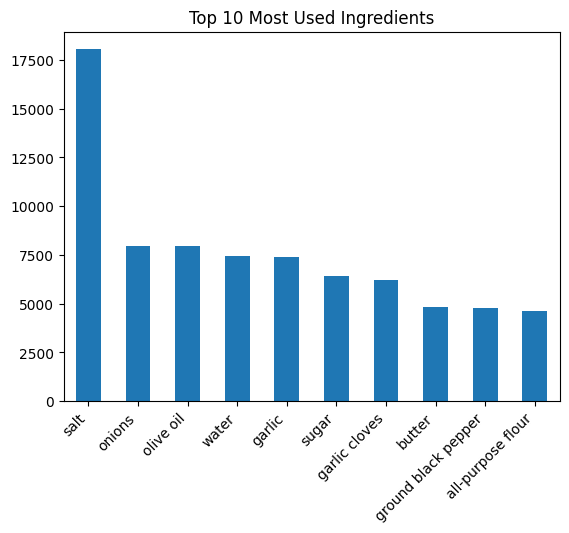

In [ ]:
ax = top_10_ingredients.plot(kind='bar', title='Top 10 Most Used Ingredients')
# Изменение названий по оси X
ax.set_xticklabels(digits, rotation=45, ha="right")
plt.show()

In [ ]:
bottom_20_ingredients = ingredient_sums.nsmallest(20)
bottom_20_ingredients.index

Index(['ingredient5', 'ingredient8', 'ingredient9', 'ingredient14',
       'ingredient20', 'ingredient21', 'ingredient22', 'ingredient27',
       'ingredient28', 'ingredient31', 'ingredient36', 'ingredient37',
       'ingredient40', 'ingredient49', 'ingredient51', 'ingredient57',
       'ingredient62', 'ingredient70', 'ingredient72', 'ingredient74'],
      dtype='object')

In [ ]:
digits = []
# Извлечение цифр с использованием регулярного выражения
for ingredient in bottom_20_ingredients.index:
    index_ingr = int(re.findall(r'\d+', ingredient)[0])
    for key, value in voc_products.items():
        if value == index_ingr:
            digits.append(key)
# digits теперь содержит список цифр из строки индекса
digits

['squid tube',
 'hard cheese',
 'whole wheat pita pockets',
 'bean curd stick',
 'Doritos Tortilla Chips',
 'protein powder',
 'cold-smoked salmon',
 'mrs. dash seasoning mix',
 'garden cress',
 'cinnamon graham crackers',
 'spicy mayonnaise',
 'cracked wheat',
 'bacon rind',
 'baobab fruit powder',
 'buttermilk ranch dressing',
 'peapods',
 'accompaniment',
 'Tapatio Hot Sauce',
 'frozen potatoes',
 'essence seasoning']

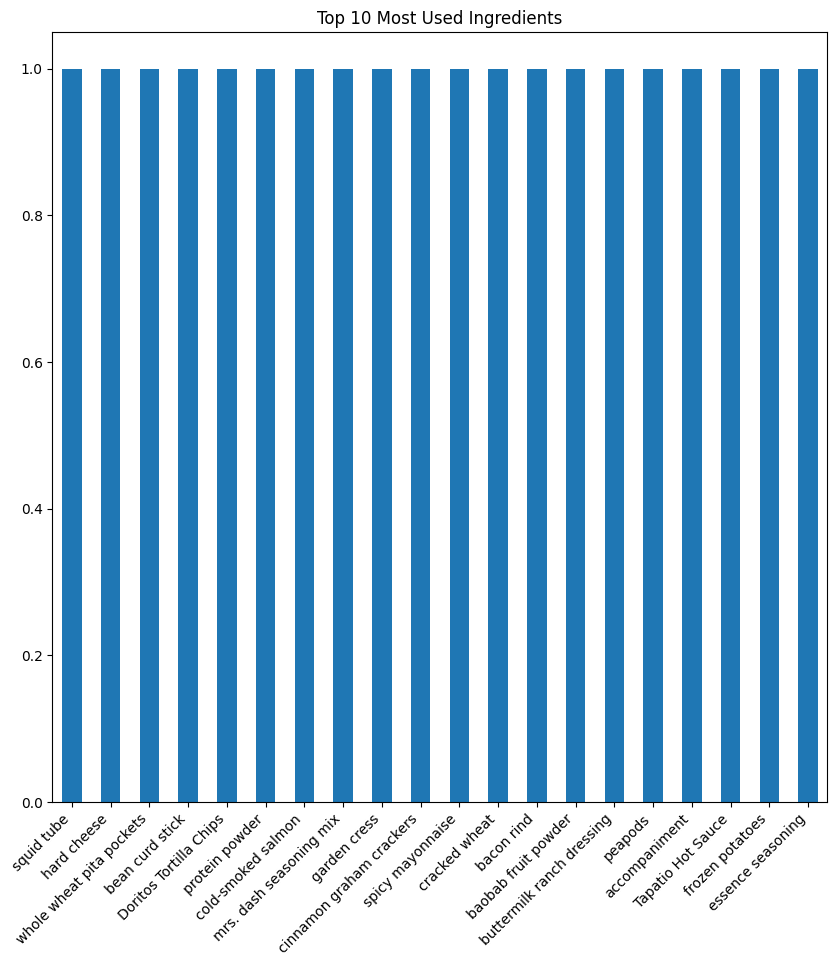

In [ ]:
plt.subplots(figsize = (10, 10))
# Гистограмма топ 10 самых мало используемых ингредиентов
ax = bottom_20_ingredients.plot(kind='bar', title='Worst 20 used ingredients')
# Изменение названий по оси X
ax.set_xticklabels(digits, rotation=45, ha="right")
plt.show()

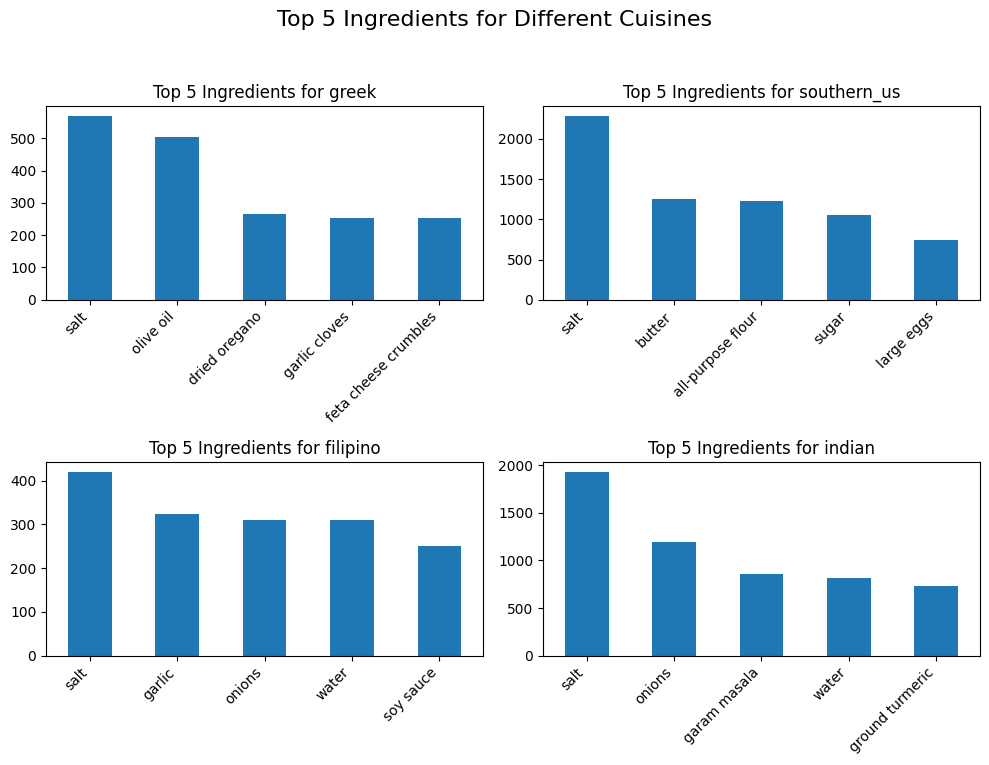

In [ ]:
# Создайте сетку из 2x2 подграфиков
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Top 5 Ingredients for Different Cuisines', fontsize=16)

# Список кухонь
cuisine_list = ['greek', 'southern_us', 'filipino', 'indian']

# Индексы подграфиков
row = 0
col = 0

for cuisine in cuisine_list:
    cuisine_df = df[df['cuisine'] == cuisine]
    top_5_ingredients_cuisine = cuisine_df[ingredient_columns].sum().nlargest(5)
    digits = []

    # Извлечение цифр с использованием регулярного выражения
    for ingredient in top_5_ingredients_cuisine.index:
        index_ingr = int(re.findall(r'\d+', ingredient)[0])
        for key, value in voc_products.items():
            if value == index_ingr:
                digits.append(key)

    # Разместите гистограмму в текущем подграфике
    ax = axs[row, col]
    top_5_ingredients_cuisine.plot(kind='bar', ax=ax)
    ax.set_xticklabels(digits, rotation=45, ha="right")
    ax.set_title(f'Top 5 Ingredients for {cuisine}')

    # Переходите к следующему подграфику в сетке
    col += 1
    if col == 2:
        col = 0
        row += 1

# Убедитесь, что расположение подграфиков хорошее
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Показать графики
plt.show()

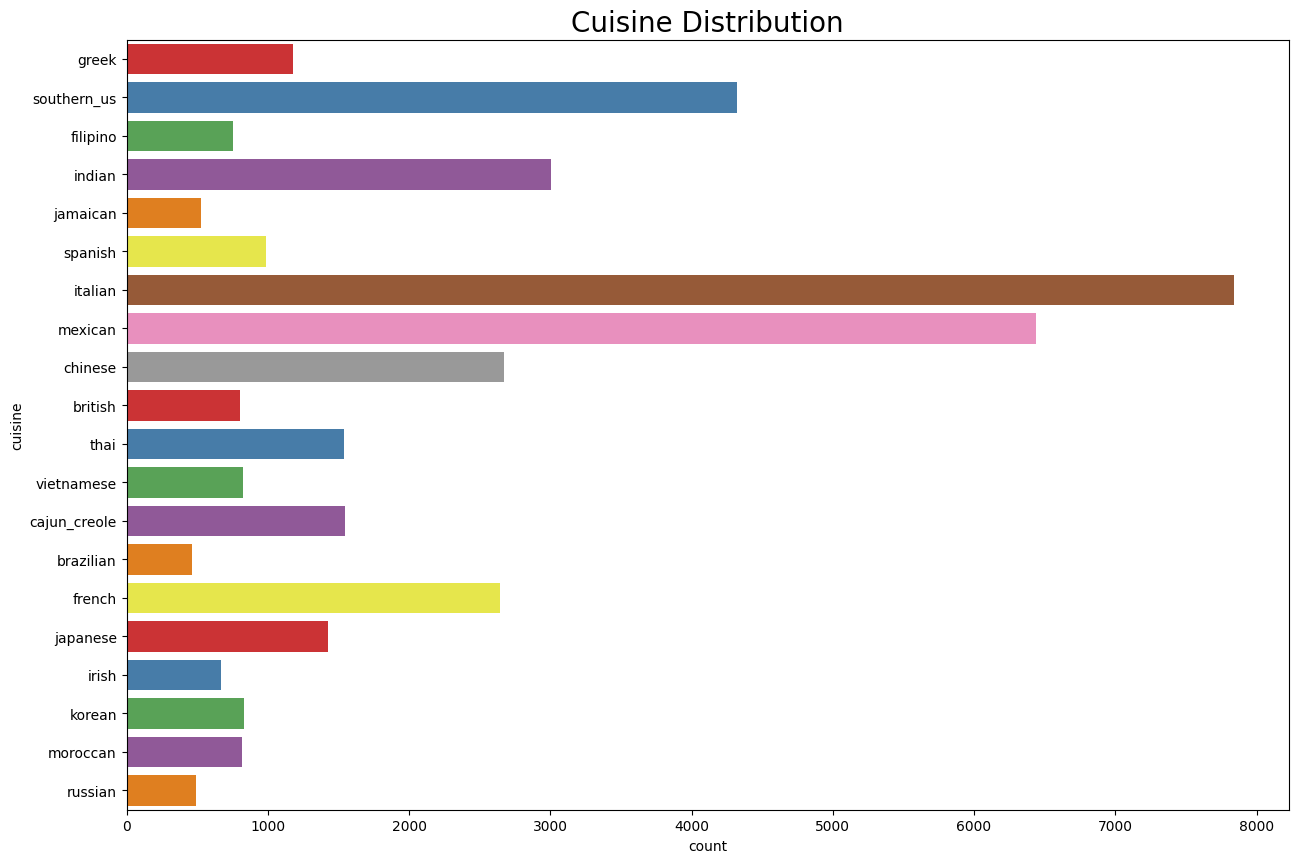

In [26]:
sns.countplot(y='cuisine', data=df,palette=sns.color_palette('Set1',15))
plt.gcf().set_size_inches(15,10)
plt.title('Cuisine Distribution',size=20)
plt.show()

# FIT

In [ ]:
def train_and_evaluate(method, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = method
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    del model
    gc.collect()
    accuracy = accuracy_score(y_test, preds)
    print(f"{method} Accuracy:", accuracy)
    return accuracy

In [ ]:
# Convert DataFrame to PyTorch tensors
X = torch.tensor(df.drop(columns=['id', 'cuisine', 'ingredients']).values, dtype=torch.float32) # float32 -> int8
massive = df['cuisine'].values
# Трансформация в массив цифр от 1 до 20
unique_classes, class_indices = np.unique(massive, return_inverse=True)
numeric_massive = class_indices + 1
y = torch.tensor(numeric_massive, dtype=torch.int8)

In [ ]:
del df
gc.collect()

20

In [ ]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X, y = X.to(device), y.to(device)

In [ ]:
# Define variants
variants = [
    KNeighborsClassifier(n_neighbors=100),
    LogisticRegression(),
    SVC(),
    MultinomialNB(),
    RandomForestClassifier()
]

acc_voc = {}
for variant in tqdm(variants):
    acc_voc[f'{variant}'] = train_and_evaluate(variant, X.cpu().numpy(), y.cpu().numpy())
    print(acc_voc[f'{variant}'])

  0%|          | 0/5 [00:00<?, ?it/s]

KNeighborsClassifier(n_neighbors=100) Accuracy: 0.48319785468867843
0.48319785468867843


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression() Accuracy: 0.775412721025727
0.775412721025727
SVC() Accuracy: 0.7528701919048018
0.7528701919048018
MultinomialNB() Accuracy: 0.7306628676778681
0.7306628676778681
RandomForestClassifier() Accuracy: 0.7133998156373083
0.7133998156373083


**KNeighborsClassifier**: Accuracy=0.48320

**LogisticRegression**: Accuracy=0.77541

**SVC**: Accuracy=0.75287

**MultinomialNB**: Accuracy=0.73066

RandomForestClassifier: Accuracy=0.71340

# Удаляем из датасета топ-10 самых популярных ингредиентов

In [10]:
def grid_Search_modify(X_train, X_test, y_train, y_test, penalty, C):
    model = LogisticRegression(penalty=penalty, C=C)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    del model
    gc.collect()
    accuracy = accuracy_score(y_test, preds)
    print(f"LogisticRegression (penalty={penalty}, C={C}): Accuracy = ", accuracy)
    return accuracy

In [11]:
ingredient_columns = df.columns[3:]
ingredient_sums = df[ingredient_columns].sum()
top_10_ingredients = ingredient_sums.nlargest(10)
print(top_10_ingredients.index)

Index(['ingredient5046', 'ingredient5221', 'ingredient164', 'ingredient2532',
       'ingredient4191', 'ingredient2387', 'ingredient2149', 'ingredient3482',
       'ingredient6302', 'ingredient3248'],
      dtype='object')


In [12]:
drop_columns = list(top_10_ingredients.index) + ['id', 'cuisine', 'ingredients']

In [13]:
# Convert DataFrame to PyTorch tensors
X = torch.tensor(df.drop(columns=drop_columns).values, dtype=torch.int8) # float32 -> int8
massive = df['cuisine'].values
# Трансформация в массив цифр от 1 до 20
unique_classes, class_indices = np.unique(massive, return_inverse=True)
numeric_massive = class_indices + 1
y = torch.tensor(numeric_massive, dtype=torch.int8)

In [14]:
del df
gc.collect()

0

In [15]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X, y = X.to(device), y.to(device)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
acc_voc_GS = {}
C_variant = [0.01, 0.1, 1, 100]
penalty_variant = [None, 'l2']

for penalty in penalty_variant:
    for C in tqdm(C_variant):
        acc_voc_GS[f'C = {C}, penalty = {penalty}'] = grid_Search_modify(X_train.cpu().numpy(), X_test.cpu().numpy(), y_train.cpu().numpy(), y_test.cpu().numpy(),penalty, C)

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 25%|██▌       | 1/4 [03:14<09:43, 194.39s/it]

LogisticRegression (penalty=None, C=0.01): Accuracy =  0.7189306963881673


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 50%|█████     | 2/4 [06:29<06:29, 194.74s/it]

LogisticRegression (penalty=None, C=0.1): Accuracy =  0.7189306963881673


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 75%|███████▌  | 3/4 [09:42<03:13, 193.79s/it]

LogisticRegression (penalty=None, C=1): Accuracy =  0.7189306963881673


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 4/4 [12:53<00:00, 193.47s/it]


LogisticRegression (penalty=None, C=100): Accuracy =  0.7189306963881673


 25%|██▌       | 1/4 [01:03<03:09, 63.26s/it]

LogisticRegression (penalty=l2, C=0.01): Accuracy =  0.621805078354144


 50%|█████     | 2/4 [03:23<03:36, 108.46s/it]

LogisticRegression (penalty=l2, C=0.1): Accuracy =  0.7438196597670326


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 75%|███████▌  | 3/4 [06:41<02:29, 149.60s/it]

LogisticRegression (penalty=l2, C=1): Accuracy =  0.7726472806502975


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 4/4 [09:52<00:00, 148.00s/it]

LogisticRegression (penalty=l2, C=100): Accuracy =  0.7303276627838766


In [28]:
acc_voc_GS

{'C = 0.01, penalty = None': 0.7189306963881673,
 'C = 0.1, penalty = None': 0.7189306963881673,
 'C = 1, penalty = None': 0.7189306963881673,
 'C = 100, penalty = None': 0.7189306963881673,
 'C = 0.01, penalty = l2': 0.621805078354144,
 'C = 0.1, penalty = l2': 0.7438196597670326,
 'C = 1, penalty = l2': 0.7726472806502975,
 'C = 100, penalty = l2': 0.7303276627838766}

# Submit:

In [27]:
model = LogisticRegression(penalty='l2', C=1, max_iter=1000)
model.fit(X_train, y_train)
preds = model.predict(X_test)
del model
gc.collect()
accuracy = accuracy_score(y_test, preds)
print(f"LogisticRegression (penalty=l2, C=1): Accuracy = ", accuracy)

LogisticRegression (penalty=l2, C=1): Accuracy =  0.7730662867677868


Best Accuracy = 0.7730662867677868